# Siamese


# Import libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import scipy
import os
import string
import csv
import random as rn

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, LSTM

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
import shutil
from sklearn import metrics
from keras import layers
from sklearn.utils import class_weight

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load dataset

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cp --verbose -R "/content/drive/MyDrive/Quora/Dataset" "/content"

'/content/drive/MyDrive/Quora/Dataset' -> '/content/Dataset'
'/content/drive/MyDrive/Quora/Dataset/validation.csv' -> '/content/Dataset/validation.csv'
'/content/drive/MyDrive/Quora/Dataset/test.csv' -> '/content/Dataset/test.csv'
'/content/drive/MyDrive/Quora/Dataset/training.csv' -> '/content/Dataset/training.csv'
'/content/drive/MyDrive/Quora/Dataset/augmented_training.csv' -> '/content/Dataset/augmented_training.csv'
'/content/drive/MyDrive/Quora/Dataset/val_cosine_score.csv' -> '/content/Dataset/val_cosine_score.csv'


# Set Parameters

In [4]:
DATASET_PATH = '/content/Dataset'

LOCAL_MODELS_FOLDER = "/content/Models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Quora/Models/Siamese"

HISTORIES_FOLDER = "/content/drive/My Drive/Quora/Histories/Siamese"

BATCH_SIZE = 64
SEED = 24

# Utility Functions

In [5]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(SEED)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(SEED)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(SEED)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001, loss='binary_crossentropy'):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss=loss,
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss=loss,
                  optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, X_train, y_train, X_validation, y_validation, epochs = 50, patience = 5, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=callbacks_list,
                    class_weight=class_weight)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')

  # save on Drive also the history object
  history_df = pd.DataFrame(history.history)
  with open(HISTORIES_FOLDER + '/' + model_name + '.csv', mode='w+') as f:
    history_df.to_csv(f)

  show_training_and_validation_performance(history)

def evaluate_model (model, X_test, y_test):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(X_test)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = y_test
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

def txt_process(input_text):
  '''
  txt_process is used to preprocess a question
  :param input_text: input string
  :return: the cleaned version of the input string
  '''
  # Removing punctuation from input text
  input_text = ''.join([x for x in input_text if x not in punctuation])
  # Cleaning the text
  input_text = re.sub(r"[^A-Za-z0-9]", " ", input_text)
  input_text = re.sub(r"\'s", " ", input_text)
  # remove stop words
  input_text = input_text.split()
  input_text = [x for x in input_text if not x in stop_words]
  input_text = " ".join(input_text)
  # return a list of words
  return(input_text)

# Preprocessing data

In [6]:
set_seed()

In [7]:
train_questions = pd.read_csv(DATASET_PATH + '/training.csv')
augmented_train_questions = pd.read_csv(DATASET_PATH + '/augmented_training.csv')
validation_questions = pd.read_csv(DATASET_PATH + '/validation.csv')
test_questions = pd.read_csv(DATASET_PATH + '/test.csv')

In [8]:
train_questions

,id,qid1,qid2,question1,question2,is_duplicate
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1
...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1


In [9]:
train_questions['question1_cleaned'] = train_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
train_questions['question2_cleaned'] = train_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

augmented_train_questions['question1_cleaned'] = augmented_train_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
augmented_train_questions['question2_cleaned'] = augmented_train_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

validation_questions['question1_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
validation_questions['question2_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

test_questions['question1_cleaned'] = test_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
test_questions['question2_cleaned'] = test_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

In [10]:
train_questions

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area
...,...,...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1,Is true US funding ISIS,Is really true US backing ISIS
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0,How I play share market India,How I study invest Indian share market
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0,What difference laundry detergent bleach laund...,How safe use nonHE detergent HE laundry washer
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1,Would consider teaching full time job Why,Would consider teaching full time job


# Text to Feature
Let’s stack both question IDs together so we can cover all words from both columns. Then we can tokenize these words to convert them to numbers.

In [11]:
#stacking
question_text = np.hstack([train_questions.question1_cleaned, train_questions.question2_cleaned])

#tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(question_text)

#creating new columns for both ids where tokenized form of sentence is created
train_questions['tokenizer_1'] = tokenizer.texts_to_sequences(train_questions.question1_cleaned)
train_questions['tokenizer_2'] = tokenizer.texts_to_sequences(train_questions.question2_cleaned)

augmented_train_questions['tokenizer_1'] = tokenizer.texts_to_sequences(augmented_train_questions.question1_cleaned)
augmented_train_questions['tokenizer_2'] = tokenizer.texts_to_sequences(augmented_train_questions.question2_cleaned)

validation_questions['tokenizer_1'] = tokenizer.texts_to_sequences(validation_questions.question1_cleaned)
validation_questions['tokenizer_2'] = tokenizer.texts_to_sequences(validation_questions.question2_cleaned)

test_questions['tokenizer_1'] = tokenizer.texts_to_sequences(test_questions.question1_cleaned)
test_questions['tokenizer_2'] = tokenizer.texts_to_sequences(test_questions.question2_cleaned)

train_questions.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[3, 2, 521, 4904, 1, 465, 3145]","[1, 1602, 465, 46, 14381, 12, 2222, 7715, 4904..."
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[4, 28362, 291, 4729, 32475, 12230, 1099, 144,...","[4, 134, 12, 207, 403, 75955, 6163, 2007, 1220..."
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[1, 13, 163, 333, 43, 124, 417]","[41, 13, 180, 796, 769, 10, 43, 124, 417]"
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[1, 14, 118, 474, 1191, 1142, 411]","[1, 14, 49, 12, 474, 489, 91, 411]"
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[3, 2, 3378, 6389, 701]","[1, 5, 17, 3378, 6389, 618]"


In [12]:
train_questions['tokenizer'] = train_questions['tokenizer_1'] + train_questions['tokenizer_2']
augmented_train_questions['tokenizer'] = augmented_train_questions['tokenizer_1'] + augmented_train_questions['tokenizer_2']
validation_questions['tokenizer'] = validation_questions['tokenizer_1'] + validation_questions['tokenizer_2']
test_questions['tokenizer'] = test_questions['tokenizer_1'] + test_questions['tokenizer_2']

# defining max length
m_len = 25

# max tokens
max_token = np.max(train_questions.tokenizer.max())
print("Max token: ", max_token)
train_questions

Max token:  75937


,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2,tokenizer
0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[3, 2, 521, 4904, 1, 465, 3145]","[1, 1602, 465, 46, 14381, 12, 2222, 7715, 4904...","[3, 2, 521, 4904, 1, 465, 3145, 1, 1602, 465, ..."
1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[4, 28362, 291, 4729, 32475, 12230, 1099, 144,...","[4, 134, 12, 207, 403, 75955, 6163, 2007, 1220...","[4, 28362, 291, 4729, 32475, 12230, 1099, 144,..."
2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[1, 13, 163, 333, 43, 124, 417]","[41, 13, 180, 796, 769, 10, 43, 124, 417]","[1, 13, 163, 333, 43, 124, 417, 41, 13, 180, 7..."
3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[1, 14, 118, 474, 1191, 1142, 411]","[1, 14, 49, 12, 474, 489, 91, 411]","[1, 14, 118, 474, 1191, 1142, 411, 1, 14, 49, ..."
4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[3, 2, 3378, 6389, 701]","[1, 5, 17, 3378, 6389, 618]","[3, 2, 3378, 6389, 701, 1, 5, 17, 3378, 6389, ..."
...,...,...,...,...,...,...,...,...,...,...,...
323426,189944,8395,34814,Is it true that the US is funding ISIS?,Is it really true that US is backing ISIS?,1,Is true US funding ISIS,Is really true US backing ISIS,"[6, 179, 37, 1577, 1303]","[6, 78, 179, 37, 10458, 1303]","[6, 179, 37, 1577, 1303, 6, 78, 179, 37, 10458..."
323427,330730,110579,457526,How do I play in share market in India?,How can I study and invest in the Indian share...,0,How I play share market India,How I study invest Indian share market,"[3, 2, 230, 675, 292, 9]","[3, 2, 149, 490, 36, 675, 292]","[3, 2, 230, 675, 292, 9, 3, 2, 149, 490, 36, 6..."
323428,143114,226824,175127,What is the difference between laundry deterge...,How safe is it to use non-HE detergent in a HE...,0,What difference laundry detergent bleach laund...,How safe use nonHE detergent HE laundry washer,"[1, 27, 7494, 6194, 3492, 7494, 6194, 43, 3492]","[3, 203, 31, 36565, 6194, 1288, 7494, 10331]","[1, 27, 7494, 6194, 3492, 7494, 6194, 43, 3492..."
323429,10918,21121,21122,Would you consider teaching as a full time job...,Would you consider teaching as a full time job?,1,Would consider teaching full time job Why,Would consider teaching full time job,"[14, 994, 2741, 622, 24, 53, 4]","[14, 994, 2741, 622, 24, 53]","[14, 994, 2741, 622, 24, 53, 4, 14, 994, 2741,..."


# Download pre-trained word embeddings (GloVe)
Let's download pre-trained GloVe embeddings. The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d /content/glove

--2022-03-08 07:55:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-08 07:55:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-08 07:55:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## 50D embeddings

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [ ]:
glove_dir = 'glove'
path_to_glove_file = os.path.join(
    glove_dir, "glove.6B.50d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index $i$ is the pre-trained vector for the word of index $i$ in our tokenizer's vocabulary.

In [ ]:
num_tokens = len(tokenizer.word_index) + 1
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 57348 words (39340 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training).

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    input_length=(m_len,),
    weights=[embedding_matrix],
    trainable=False,
)

### Experiment 1: LSTM

In [ ]:
lstm_units = 50

In [ ]:
lstm_layer = layers.LSTM(lstm_units)

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 50)       4834450     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 lstm (LSTM)                    (None, 50)           20200       ['embedding[0][0]',          

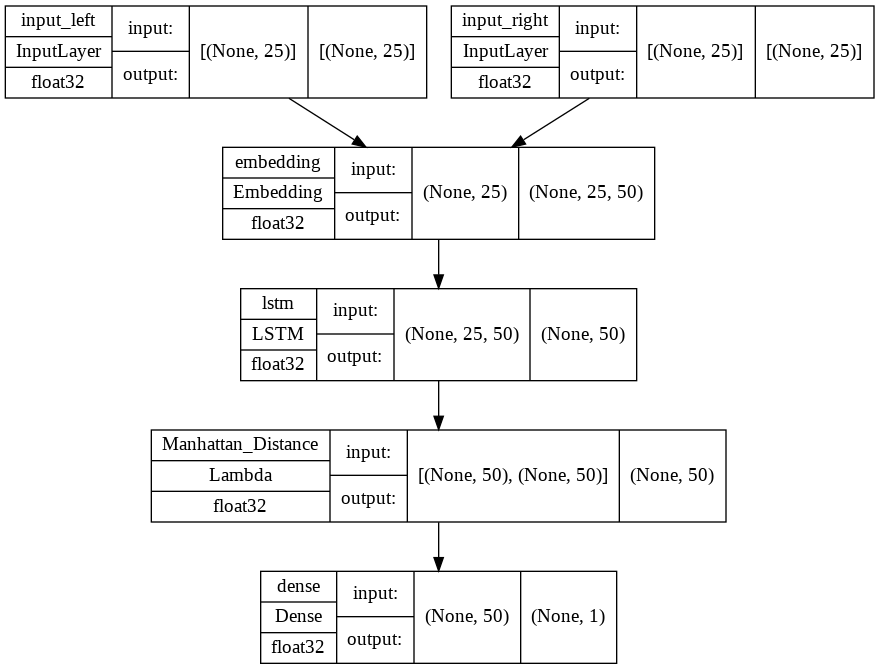

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.7138
Epoch 1: val_loss improved from inf to 0.17011, saving model to /content/Models/siamese_lstm_glove-50_m-len-25.h5
5054/5054 [==============================] - 159s 30ms/step - loss: 0.1843 - accuracy: 0.7138 - val_loss: 0.1701 - val_accuracy: 0.7456
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.7621
Epoch 2: val_loss improved from 0.17011 to 0.16132, saving model to /content/Models/siamese_lstm_glove-50_m-len-25.h5
5054/5054 [==============================] - 157s 31ms/step - loss: 0.1619 - accuracy: 0.7621 - val_loss: 0.1613 - val_accuracy: 0.7626
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.7771
Epoch 3: val_loss improved from 0.16132 to 0.15720, saving model to /content/Models/siamese_lstm_glove-50_m-len-25.h5
5054/5054 [==============================] - 151s 30ms/step - loss: 0.1538 - accurac

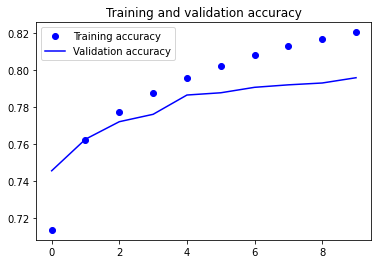

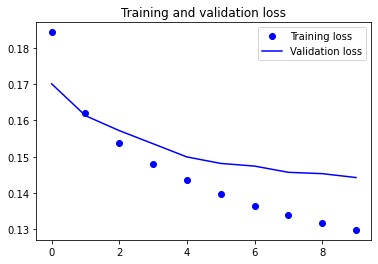

In [ ]:
run_model(model, "siamese_lstm_glove-50_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8468    0.8208    0.8336     25348
           1     0.7135    0.7504    0.7315     15080

    accuracy                         0.7945     40428
   macro avg     0.7802    0.7856    0.7825     40428
weighted avg     0.7971    0.7945    0.7955     40428



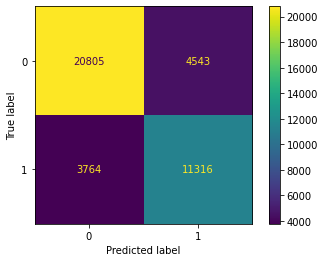

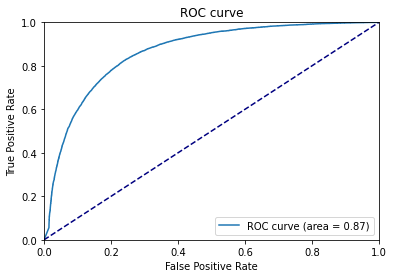

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 2: Bi-directional LSTM

In [ ]:
lstm_units = 10

In [ ]:
lstm_layer = layers.Bidirectional(layers.LSTM(
    lstm_units,
    dropout=0.2,
    recurrent_dropout=0.2
))

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 50)       4834450     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 20)           4880        ['embedding[0][0]',          

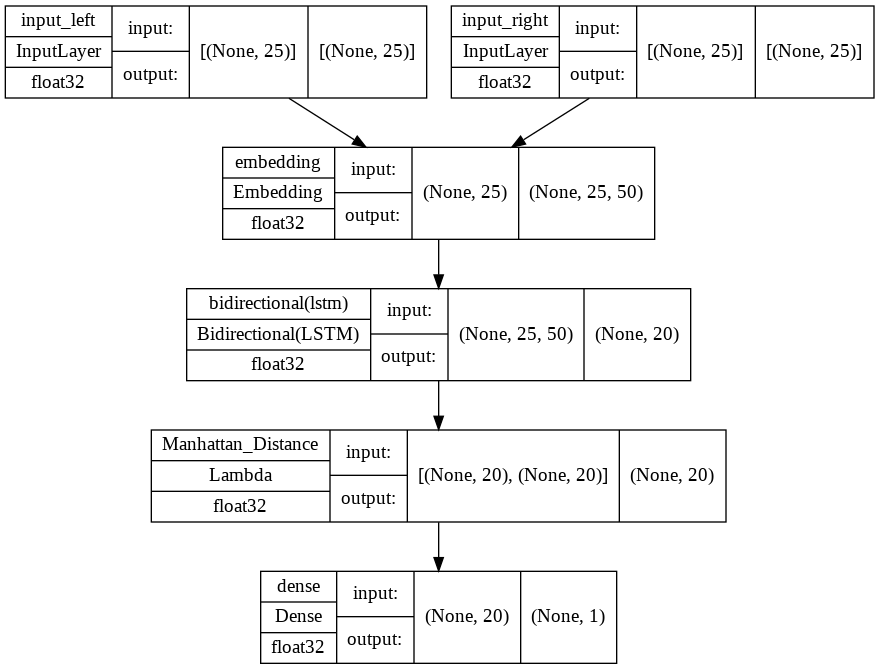

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.6811
Epoch 1: val_loss improved from inf to 0.18446, saving model to /content/Models/siamese_glove-50_m-len-25.h5
5054/5054 [==============================] - 426s 82ms/step - loss: 0.1970 - accuracy: 0.6811 - val_loss: 0.1845 - val_accuracy: 0.7133
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.7151
Epoch 2: val_loss improved from 0.18446 to 0.17785, saving model to /content/Models/siamese_glove-50_m-len-25.h5
5054/5054 [==============================] - 419s 83ms/step - loss: 0.1825 - accuracy: 0.7151 - val_loss: 0.1778 - val_accuracy: 0.7244
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.7243
Epoch 3: val_loss improved from 0.17785 to 0.17785, saving model to /content/Models/siamese_glove-50_m-len-25.h5
5054/5054 [==============================] - 423s 84ms/step - loss: 0.1778 - accuracy: 0.7243 - val

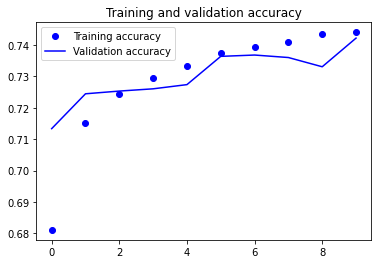

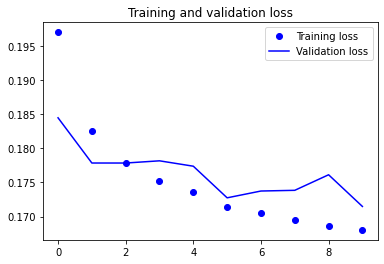

In [ ]:
run_model(model, "siamese_glove-50_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8676    0.6931    0.7706     25348
           1     0.6144    0.8221    0.7033     15080

    accuracy                         0.7412     40428
   macro avg     0.7410    0.7576    0.7369     40428
weighted avg     0.7731    0.7412    0.7455     40428



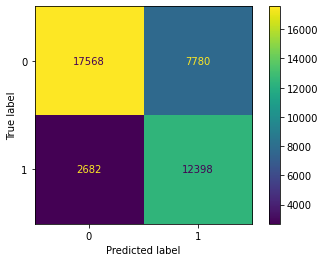

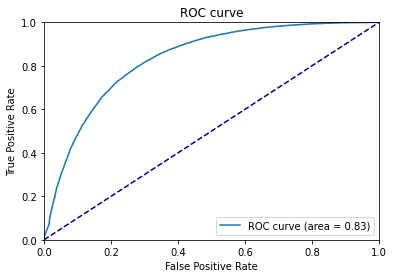

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 3: LSTM with trainable embeddings

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    input_length=(m_len,),
    weights=[embedding_matrix],
    trainable=True,
)

In [ ]:
lstm_units = 50

In [ ]:
lstm_layer = layers.LSTM(lstm_units, dropout=0.2)

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 50)       4834450     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 lstm (LSTM)                    (None, 50)           20200       ['embedding[0][0]',          

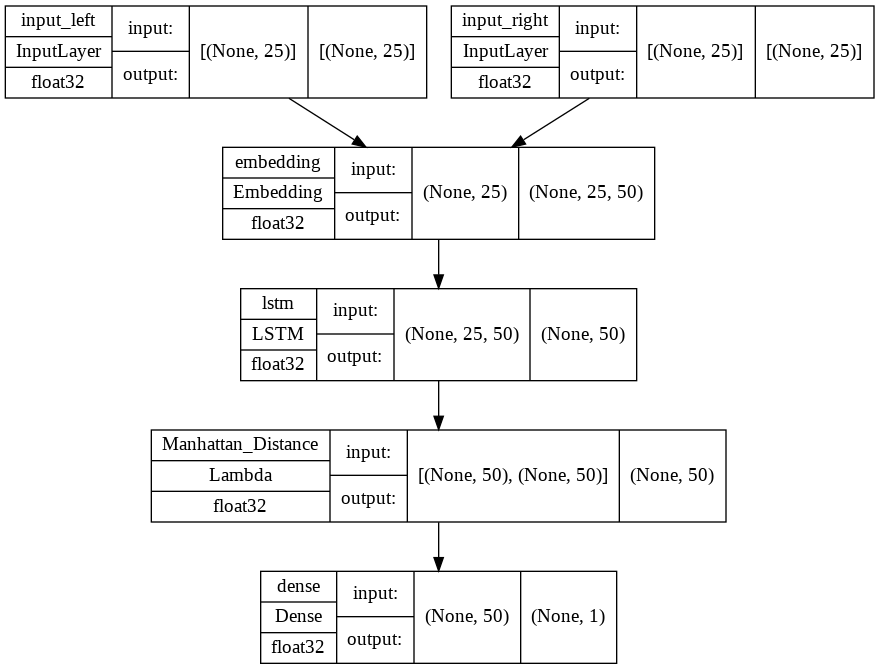

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.7120
Epoch 1: val_loss improved from inf to 0.15957, saving model to /content/Models/siamese_lstm_trainable_glove-50_m-len-25.h5
5054/5054 [==============================] - 430s 84ms/step - loss: 0.1853 - accuracy: 0.7120 - val_loss: 0.1596 - val_accuracy: 0.7660
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.7728
Epoch 2: val_loss improved from 0.15957 to 0.14686, saving model to /content/Models/siamese_lstm_trainable_glove-50_m-len-25.h5
5054/5054 [==============================] - 425s 84ms/step - loss: 0.1540 - accuracy: 0.7728 - val_loss: 0.1469 - val_accuracy: 0.7872
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.7953
Epoch 3: val_loss improved from 0.14686 to 0.14023, saving model to /content/Models/siamese_lstm_trainable_glove-50_m-len-25.h5
5054/5054 [==============================] - 421s 83ms

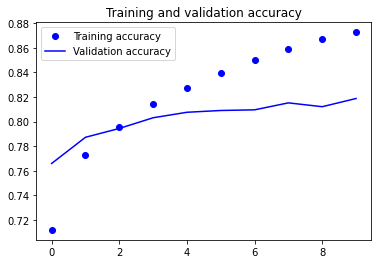

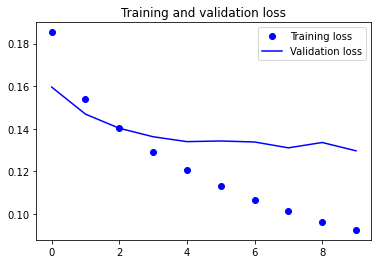

In [ ]:
run_model(model, "siamese_lstm_trainable_glove-50_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8903    0.8087    0.8475     25348
           1     0.7214    0.8325    0.7730     15080

    accuracy                         0.8176     40428
   macro avg     0.8058    0.8206    0.8102     40428
weighted avg     0.8273    0.8176    0.8197     40428



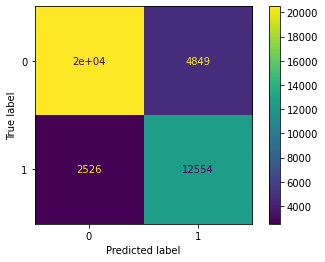

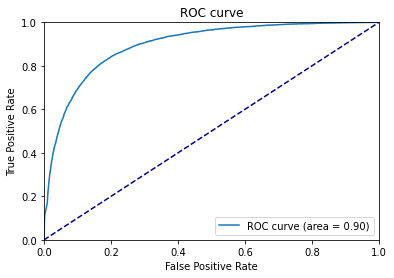

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

## 100D embeddings

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [ ]:
glove_dir = 'glove'
path_to_glove_file = os.path.join(
    glove_dir, "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index $i$ is the pre-trained vector for the word of index $i$ in our tokenizer's vocabulary.

In [ ]:
num_tokens = len(tokenizer.word_index) + 1
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 57348 words (39340 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training).

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    input_length=(m_len,),
    weights=[embedding_matrix],
    trainable=False,
)

### Experiment 1: LSTM

In [ ]:
lstm_units = 50

In [ ]:
lstm_layer = layers.LSTM(lstm_units)

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 lstm (LSTM)                    (None, 50)           30200       ['embedding[0][0]',          

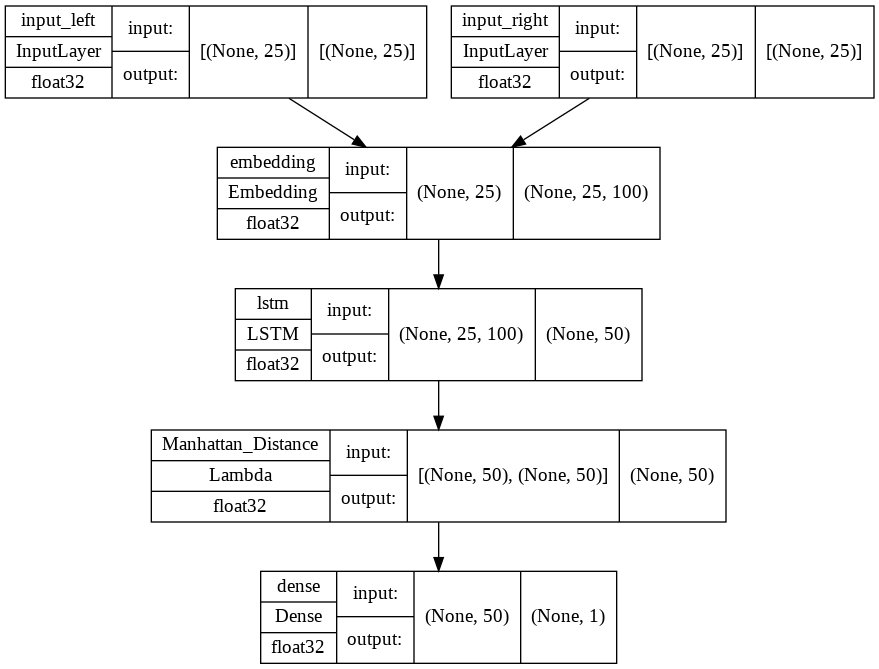

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.7210
Epoch 1: val_loss improved from inf to 0.16635, saving model to /content/Models/siamese_lstm_glove-100_m-len-25.h5
5054/5054 [==============================] - 179s 34ms/step - loss: 0.1816 - accuracy: 0.7210 - val_loss: 0.1663 - val_accuracy: 0.7573
Epoch 2/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.7748
Epoch 2: val_loss improved from 0.16635 to 0.15531, saving model to /content/Models/siamese_lstm_glove-100_m-len-25.h5
5054/5054 [==============================] - 172s 34ms/step - loss: 0.1554 - accuracy: 0.7748 - val_loss: 0.1553 - val_accuracy: 0.7753
Epoch 3/10
5053/5054 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.7921
Epoch 3: val_loss improved from 0.15531 to 0.14854, saving model to /content/Models/siamese_lstm_glove-100_m-len-25.h5
5054/5054 [==============================] - 175s 35ms/step - loss: 0.1453 - accu

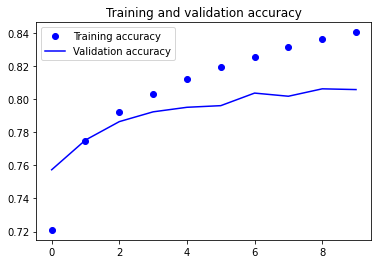

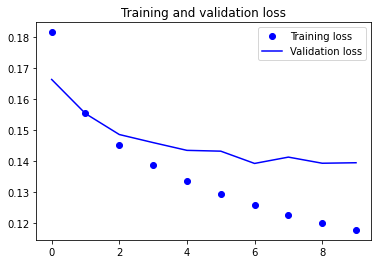

In [ ]:
run_model(model, "siamese_lstm_glove-100_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8336    0.8572    0.8452     25348
           1     0.7479    0.7123    0.7297     15080

    accuracy                         0.8032     40428
   macro avg     0.7908    0.7848    0.7875     40428
weighted avg     0.8016    0.8032    0.8021     40428



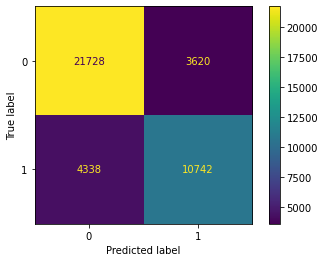

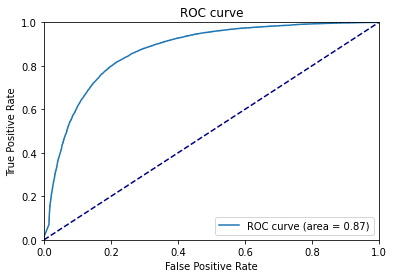

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 2: Bi-directional LSTM

In [ ]:
lstm_units = 10

In [ ]:
lstm_layer = layers.Bidirectional(layers.LSTM(
    lstm_units,
    dropout=0.2,
    recurrent_dropout=0.2
))

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 20)           8880        ['embedding[2][0]',        

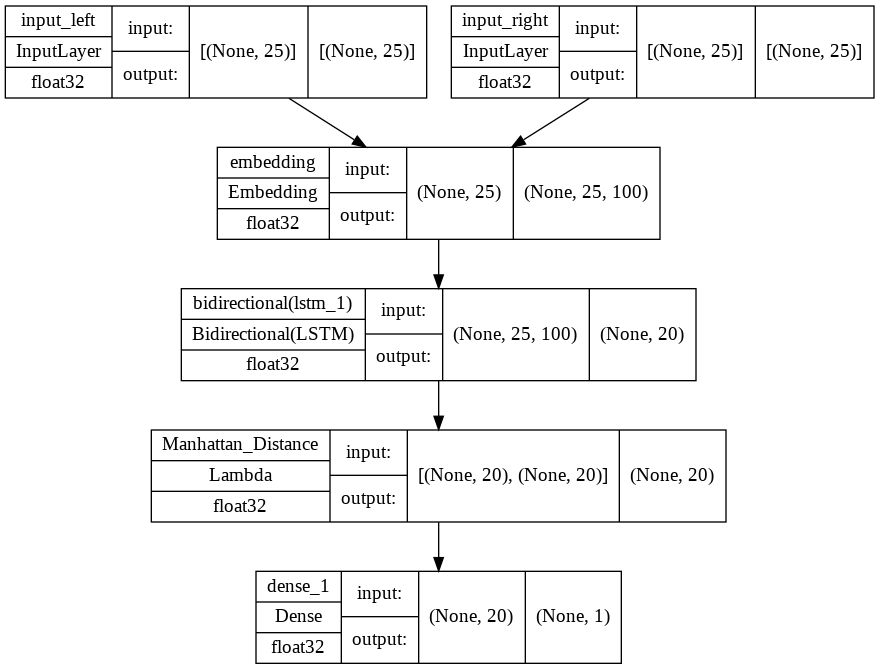

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.6984
Epoch 1: val_loss improved from inf to 0.17335, saving model to /content/Models/siamese_glove-100_m-len-25.h5
5054/5054 [==============================] - 533s 102ms/step - loss: 0.1911 - accuracy: 0.6984 - val_loss: 0.1733 - val_accuracy: 0.7410
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.7378
Epoch 2: val_loss improved from 0.17335 to 0.16386, saving model to /content/Models/siamese_glove-100_m-len-25.h5
5054/5054 [==============================] - 522s 103ms/step - loss: 0.1727 - accuracy: 0.7378 - val_loss: 0.1639 - val_accuracy: 0.7553
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.7460
Epoch 3: val_loss improved from 0.16386 to 0.16230, saving model to /content/Models/siamese_glove-100_m-len-25.h5
5054/5054 [==============================] - 523s 104ms/step - loss: 0.1682 - accuracy: 0.7460

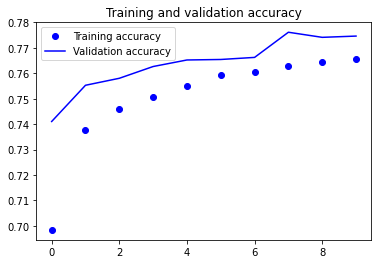

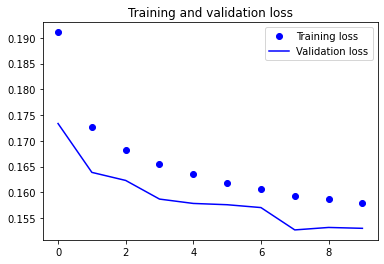

In [ ]:
run_model(model, "siamese_glove-100_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8388    0.7951    0.8164     25348
           1     0.6833    0.7432    0.7120     15080

    accuracy                         0.7757     40428
   macro avg     0.7611    0.7692    0.7642     40428
weighted avg     0.7808    0.7757    0.7775     40428



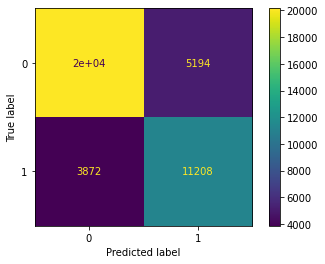

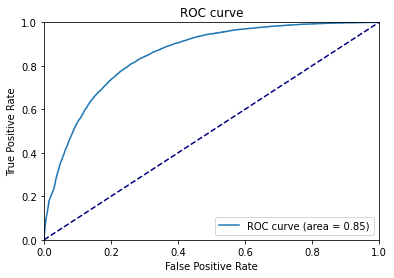

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 3: LSTM with trainable embedding

Qui proviamo 15 m_len, 100 emb, LSTM con embedding trainable, e loss binary_crossentropy

In [ ]:
m_len = 15

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    input_length=(m_len,),
    weights=[embedding_matrix],
    trainable=True,
)

In [ ]:
lstm_units = 50

In [ ]:
lstm_layer = layers.LSTM(lstm_units)

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 15)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 15)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 15, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 lstm_4 (LSTM)                  (None, 50)           30200       ['embedding_3[2][0]',      

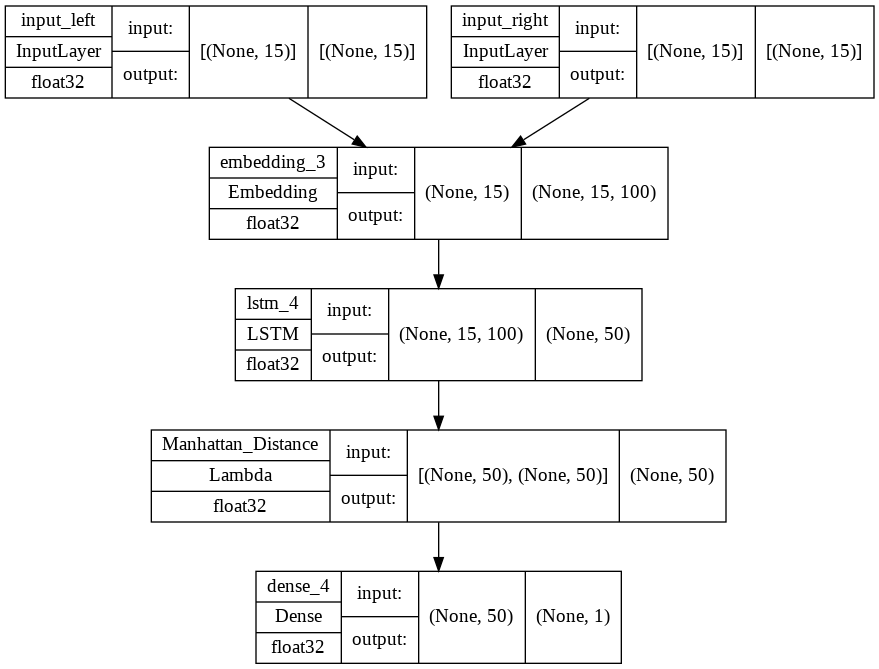

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.7706
Epoch 1: val_loss improved from inf to 0.41413, saving model to /content/Models/siamese_glove-100_m-len-15_binaryce.h5
5054/5054 [==============================] - 655s 128ms/step - loss: 0.4666 - accuracy: 0.7706 - val_loss: 0.4141 - val_accuracy: 0.8084
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.8422
Epoch 2: val_loss improved from 0.41413 to 0.38466, saving model to /content/Models/siamese_glove-100_m-len-15_binaryce.h5
5054/5054 [==============================] - 628s 124ms/step - loss: 0.3503 - accuracy: 0.8422 - val_loss: 0.3847 - val_accuracy: 0.8249
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8759
Epoch 3: val_loss improved from 0.38466 to 0.38415, saving model to /content/Models/siamese_glove-100_m-len-15_binaryce.h5
5054/5054 [==============================] - 618s 122ms/step - loss

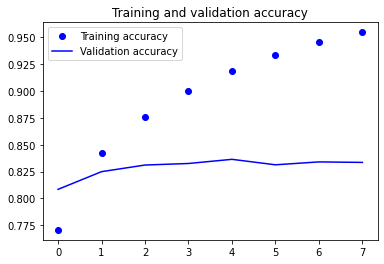

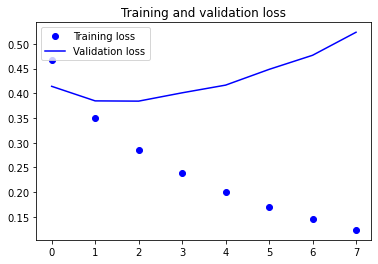

In [ ]:
run_model(model, "siamese_glove-100_m-len-15_binaryce", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8625    0.8733    0.8679     25348
           1     0.7825    0.7660    0.7741     15080

    accuracy                         0.8333     40428
   macro avg     0.8225    0.8197    0.8210     40428
weighted avg     0.8327    0.8333    0.8329     40428



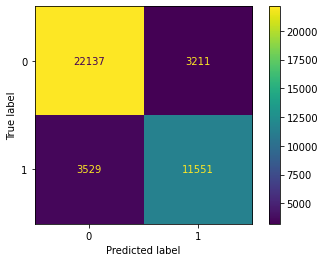

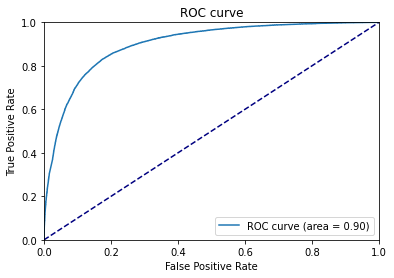

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 4: LSTM + Dropout with trainable embedding

Qui proviamo 25 m_len, 100 emb, LSTM con dropout, embedding trainable, e loss binary_crossentropy

In [ ]:
m_len = 25

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    input_length=(m_len,),
    weights=[embedding_matrix],
    trainable=True,
)

In [ ]:
lstm_units = 50

In [ ]:
lstm_layer = layers.LSTM(lstm_units, dropout=0.5)

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 lstm_5 (LSTM)                  (None, 50)           30200       ['embedding_4[0][0]',      

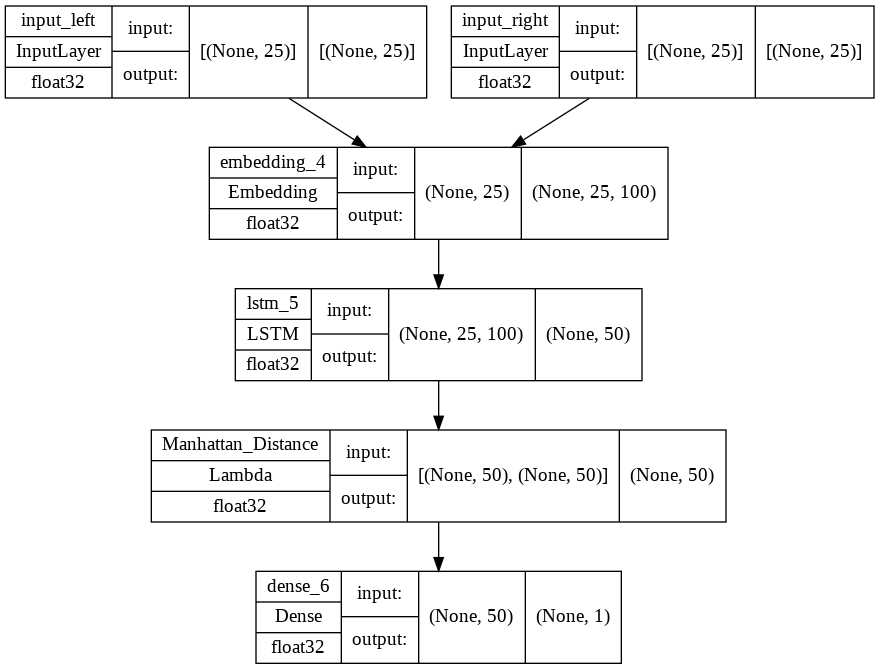

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
5054/5054 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7007
Epoch 1: val_loss improved from inf to 0.51319, saving model to /content/Models/siamese_glove-100_m-len-25_binaryce.h5
5054/5054 [==============================] - 737s 145ms/step - loss: 0.5639 - accuracy: 0.7007 - val_loss: 0.5132 - val_accuracy: 0.7460
Epoch 2/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7567
Epoch 2: val_loss improved from 0.51319 to 0.47371, saving model to /content/Models/siamese_glove-100_m-len-25_binaryce.h5
5054/5054 [==============================] - 732s 145ms/step - loss: 0.4928 - accuracy: 0.7567 - val_loss: 0.4737 - val_accuracy: 0.7722
Epoch 3/10
5054/5054 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.7755
Epoch 3: val_loss improved from 0.47371 to 0.45677, saving model to /content/Models/siamese_glove-100_m-len-25_binaryce.h5
5054/5054 [==============================] - 715s 141ms/step - loss

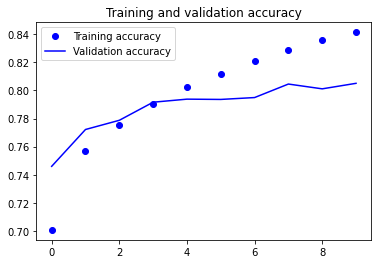

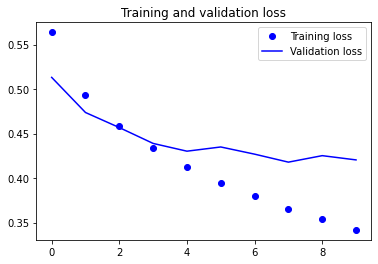

In [ ]:
run_model(model, "siamese_glove-100_m-len-25_binaryce", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8868    0.7902    0.8357     25348
           1     0.7019    0.8304    0.7608     15080

    accuracy                         0.8052     40428
   macro avg     0.7943    0.8103    0.7982     40428
weighted avg     0.8178    0.8052    0.8077     40428



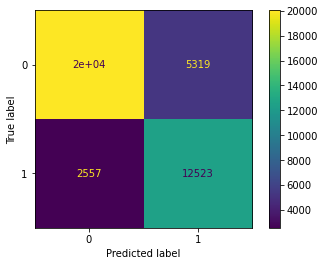

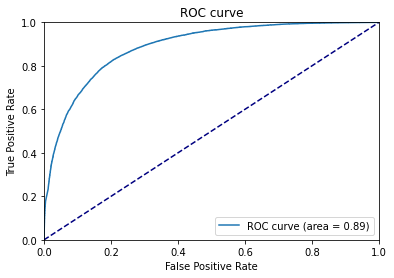

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 5: Bi-directional LSTM with trainable embedding

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_glove-100_m-len-25.h5'))

In [ ]:
for layer in model.layers:
  if layer.name == 'embedding':
    layer.trainable = True
compile_model(model, loss='mse', learning_rate=1e-5)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 20)           8880        ['embedding[0][0]',        

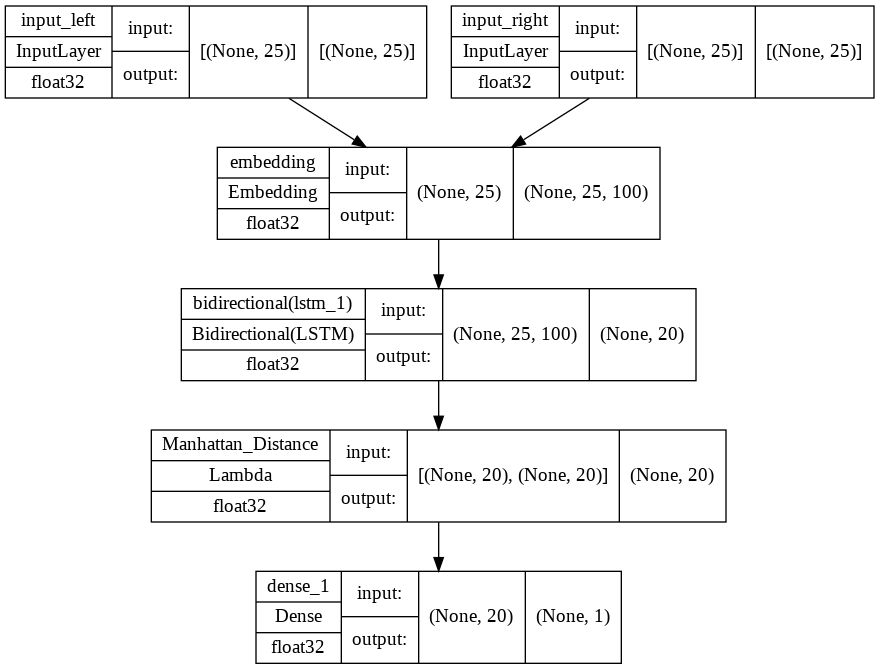

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
m_len = 25

In [ ]:
x_train_left, x_train_right = get_samples(train_questions, m_len)
y_train = train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_bi-finetune_1_glove-100_m-len-25.h5'))

In [ ]:
compile_model(model, loss='mse')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 20)           8880        ['embedding[0][0]',        

Epoch 1/50
5054/5054 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.7876
Epoch 1: val_loss improved from inf to 0.13554, saving model to /content/Models/siamese_bi-finetune_glove-100_m-len-25.h5
5054/5054 [==============================] - 1120s 219ms/step - loss: 0.1451 - accuracy: 0.7876 - val_loss: 0.1355 - val_accuracy: 0.8029
Epoch 2/50
5054/5054 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.8225
Epoch 2: val_loss improved from 0.13554 to 0.12859, saving model to /content/Models/siamese_bi-finetune_glove-100_m-len-25.h5
5054/5054 [==============================] - 1098s 217ms/step - loss: 0.1245 - accuracy: 0.8225 - val_loss: 0.1286 - val_accuracy: 0.8146
Epoch 3/50
5054/5054 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.8441
Epoch 3: val_loss improved from 0.12859 to 0.12719, saving model to /content/Models/siamese_bi-finetune_glove-100_m-len-25.h5
5054/5054 [==============================] - 1096s 217ms

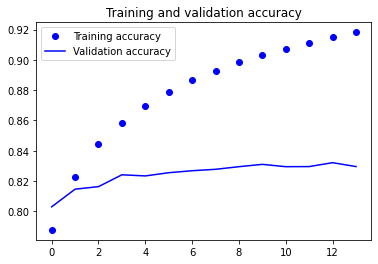

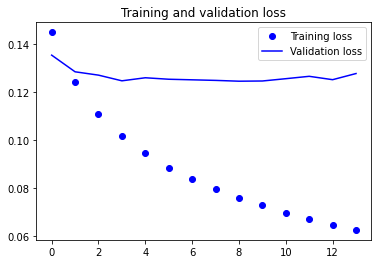

In [ ]:
run_model(model, "siamese_bi-finetune_glove-100_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 50)

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_bi-finetune_glove-100_m-len-25.h5'))

Classification report: 
              precision    recall  f1-score   support

           0     0.8862    0.8371    0.8610     25348
           1     0.7495    0.8193    0.7829     15080

    accuracy                         0.8305     40428
   macro avg     0.8179    0.8282    0.8219     40428
weighted avg     0.8352    0.8305    0.8318     40428



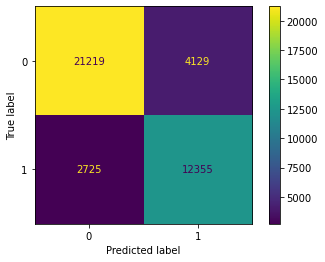

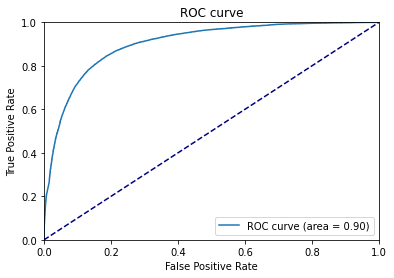

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 6: Bi-directional LSTM + Data Augmentation

In [ ]:
augmented_train_questions

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2,tokenizer
0,0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[3, 2, 521, 4904, 1, 465, 3145]","[1, 1602, 465, 46, 14381, 12, 2222, 7715, 4904...","[3, 2, 521, 4904, 1, 465, 3145, 1, 1602, 465, ..."
1,1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[4, 28362, 291, 4729, 32475, 12230, 1099, 144,...","[4, 134, 12, 207, 403, 75955, 6163, 2007, 1220...","[4, 28362, 291, 4729, 32475, 12230, 1099, 144,..."
2,2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[1, 13, 163, 333, 43, 124, 417]","[41, 13, 180, 796, 769, 10, 43, 124, 417]","[1, 13, 163, 333, 43, 124, 417, 41, 13, 180, 7..."
3,3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[1, 14, 118, 474, 1191, 1142, 411]","[1, 14, 49, 12, 474, 489, 91, 411]","[1, 14, 118, 474, 1191, 1142, 411, 1, 14, 49, ..."
4,4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[3, 2, 3378, 6389, 701]","[1, 5, 17, 3378, 6389, 618]","[3, 2, 3378, 6389, 701, 1, 5, 17, 3378, 6389, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
408409,408409,212039,317022,2044,"What do you guys think about this movie? ""Inte...",What do you think about the movie Interstellar?,1,What guys think movie Interstellar,What think movie Interstellar,"[1, 525, 34, 94, 3936]","[1, 34, 94, 3936]","[1, 525, 34, 94, 3936, 1, 34, 94, 3936]"
408410,408410,371315,501930,501929,Why is punctuation so important in a poem?,Why is punctuation so important in poetry?,1,Why punctuation important poem,Why punctuation important poetry,"[4, 11619, 136, 2543]","[4, 11619, 136, 4206]","[4, 11619, 136, 2543, 4, 11619, 136, 4206]"
408411,408411,107413,18588,5987,What is the cut off of KVPY SA stream?,How was your KVPY sa 2016?,1,What cut KVPY SA stream,How KVPY sa 2016,"[1, 951, 1335, 1694, 1331]","[3, 1335, 1694, 64]","[1, 951, 1335, 1694, 1331, 3, 1335, 1694, 64]"
408412,408412,219121,325905,309616,Why is diversity considered a good thing?,Is diversity a good thing?,1,Why diversity considered good thing,Is diversity good thing,"[4, 5519, 312, 13, 103]","[6, 5519, 13, 103]","[4, 5519, 312, 13, 103, 6, 5519, 13, 103]"


In [ ]:
m_len = 25

In [ ]:
lstm_units = 10

In [ ]:
lstm_layer = layers.Bidirectional(layers.LSTM(
    lstm_units,
    dropout=0.2,
    recurrent_dropout=0.2
))

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 20)           8880        ['embedding[0][0]',          

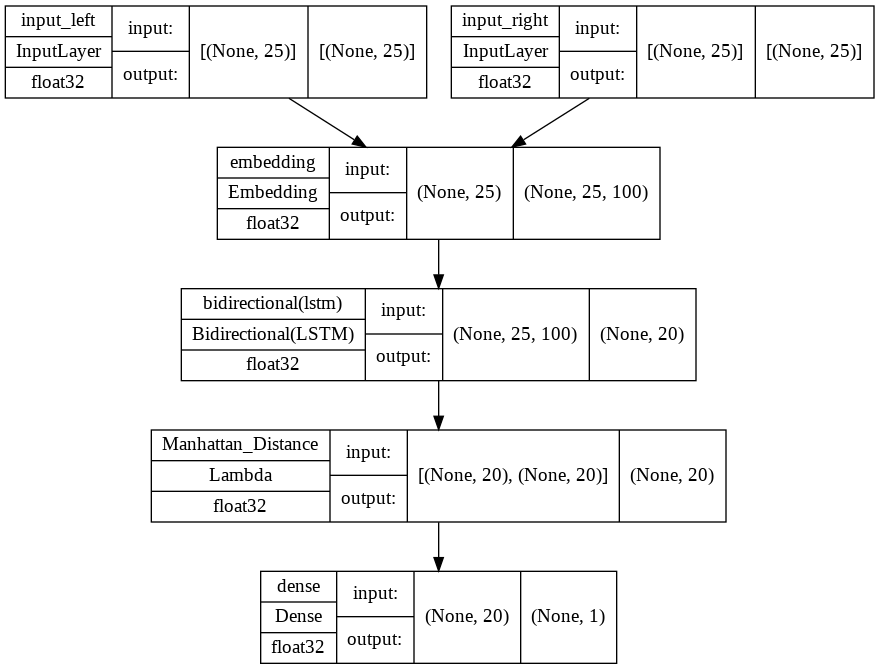

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(augmented_train_questions, m_len)
y_train = augmented_train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

Epoch 1/10
6382/6382 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.6992
Epoch 1: val_loss improved from inf to 0.18296, saving model to /content/Models/siamese_bi_augm_glove-100_m-len-15.h5
6382/6382 [==============================] - 680s 104ms/step - loss: 0.1957 - accuracy: 0.6992 - val_loss: 0.1830 - val_accuracy: 0.7157
Epoch 2/10
6382/6382 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.7375
Epoch 2: val_loss improved from 0.18296 to 0.18003, saving model to /content/Models/siamese_bi_augm_glove-100_m-len-15.h5
6382/6382 [==============================] - 643s 101ms/step - loss: 0.1763 - accuracy: 0.7375 - val_loss: 0.1800 - val_accuracy: 0.7246
Epoch 3/10
6382/6382 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.7470
Epoch 3: val_loss improved from 0.18003 to 0.17795, saving model to /content/Models/siamese_bi_augm_glove-100_m-len-15.h5
6382/6382 [==============================] - 662s 104ms/step - loss: 0

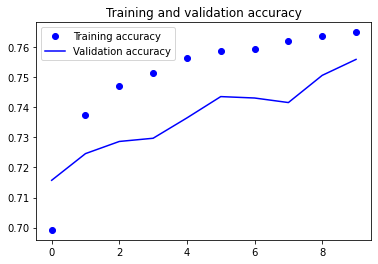

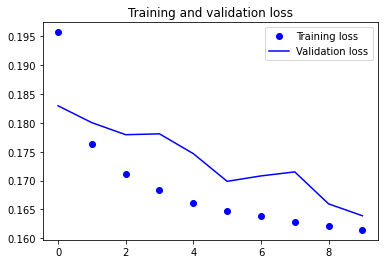

In [ ]:
run_model(model, "siamese_bi_augm_glove-100_m-len-15", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 10)

Classification report: 
              precision    recall  f1-score   support

           0     0.8913    0.6957    0.7814     25348
           1     0.6263    0.8574    0.7239     15080

    accuracy                         0.7560     40428
   macro avg     0.7588    0.7766    0.7527     40428
weighted avg     0.7925    0.7560    0.7600     40428



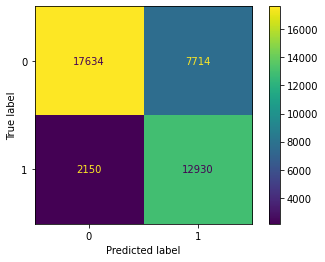

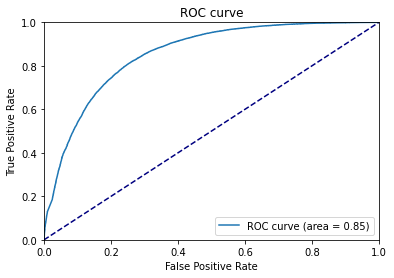

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 7: Bi-directional LSTM, higher dropout + Data Augmentation

In [ ]:
augmented_train_questions

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,tokenizer_1,tokenizer_2,tokenizer
0,0,216036,322068,322069,How can I sell at Snapdeal? What are the terms...,What are the payment terms for online marketpl...,0,How I sell Snapdeal What terms conditions,What payment terms online marketplaces like Fl...,"[3, 2, 521, 4904, 1, 465, 3145]","[1, 1602, 465, 46, 14381, 12, 2222, 7715, 4904...","[3, 2, 521, 4904, 1, 465, 3145, 1, 1602, 465, ..."
1,1,241554,353581,353582,Why are most prosecutors in American courts no...,Why does a country like USA where law enforcem...,0,Why prosecutors American courts notoriously di...,Why country like USA law enforcements strict l...,"[4, 28362, 291, 4729, 32475, 12230, 1099, 144,...","[4, 134, 12, 207, 403, 75955, 6163, 2007, 1220...","[4, 28362, 291, 4729, 32475, 12230, 1099, 144,..."
2,2,208738,312815,312816,What are some good government jobs without a c...,Are there any good companies that hire smart p...,0,What good government jobs without college degree,Are good companies hire smart people without c...,"[1, 13, 163, 333, 43, 124, 417]","[41, 13, 180, 796, 769, 10, 43, 124, 417]","[1, 13, 163, 333, 43, 124, 417, 41, 13, 180, 7..."
3,3,102714,104282,77231,What would happen if humans no longer needed t...,What would the world be like if humans didn't ...,1,What would happen humans longer needed sleep,What would world like humans didnt need sleep,"[1, 14, 118, 474, 1191, 1142, 411]","[1, 14, 49, 12, 474, 489, 91, 411]","[1, 14, 118, 474, 1191, 1142, 411, 1, 14, 49, ..."
4,4,397304,178955,34172,How do I shave my bikini line?,What is the best way to shave the bikini area?,1,How I shave bikini line,What best way shave bikini area,"[3, 2, 3378, 6389, 701]","[1, 5, 17, 3378, 6389, 618]","[3, 2, 3378, 6389, 701, 1, 5, 17, 3378, 6389, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
408409,408409,212039,317022,2044,"What do you guys think about this movie? ""Inte...",What do you think about the movie Interstellar?,1,What guys think movie Interstellar,What think movie Interstellar,"[1, 525, 34, 94, 3936]","[1, 34, 94, 3936]","[1, 525, 34, 94, 3936, 1, 34, 94, 3936]"
408410,408410,371315,501930,501929,Why is punctuation so important in a poem?,Why is punctuation so important in poetry?,1,Why punctuation important poem,Why punctuation important poetry,"[4, 11619, 136, 2543]","[4, 11619, 136, 4206]","[4, 11619, 136, 2543, 4, 11619, 136, 4206]"
408411,408411,107413,18588,5987,What is the cut off of KVPY SA stream?,How was your KVPY sa 2016?,1,What cut KVPY SA stream,How KVPY sa 2016,"[1, 951, 1335, 1694, 1331]","[3, 1335, 1694, 64]","[1, 951, 1335, 1694, 1331, 3, 1335, 1694, 64]"
408412,408412,219121,325905,309616,Why is diversity considered a good thing?,Is diversity a good thing?,1,Why diversity considered good thing,Is diversity good thing,"[4, 5519, 312, 13, 103]","[6, 5519, 13, 103]","[4, 5519, 312, 13, 103, 6, 5519, 13, 103]"


In [ ]:
m_len = 25

In [ ]:
lstm_units = 10

In [ ]:
lstm_layer = layers.Bidirectional(layers.LSTM(
    lstm_units,
    dropout=0.3,
    recurrent_dropout=0.3
))

In [ ]:
input_left = layers.Input(shape=(m_len,), name="input_left")
embedded_sequences_left = embedding_layer(input_left)
lstm_left = lstm_layer(embedded_sequences_left)
input_right = layers.Input(shape=(m_len,), name="input_right")
embedded_sequences_right = embedding_layer(input_right)
lstm_2 = lstm_layer(embedded_sequences_right)
mhd = lambda x: keras.backend.abs(x[0] - x[1]) # Manhattan Distance
merged = layers.Lambda(function=mhd, output_shape=lambda x: x[0], name='Manhattan_Distance')([lstm_left, lstm_2])
preds = layers.Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input_left, input_right], outputs=preds)
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20)          8880        ['embedding[0][0]',          

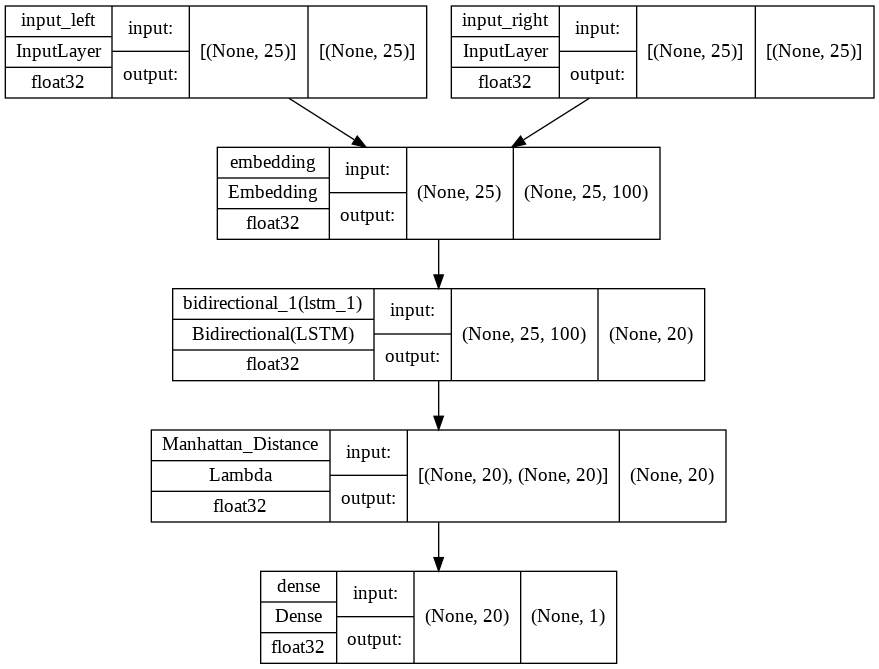

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [ ]:
x_train_left, x_train_right = get_samples(augmented_train_questions, m_len)
y_train = augmented_train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [ ]:
x_train_left.shape == x_train_right.shape

True

In [ ]:
len(x_train_left) == len(y_train)

True

In [ ]:
run_model(model, "siamese_bi_augm_0.4d_glove-100_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 50)

Epoch 1/50
6382/6382 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.6878
Epoch 1: val_loss improved from inf to 0.18320, saving model to /content/Models/siamese_bi_augm_0.4d_glove-100_m-len-25.h5
6382/6382 [==============================] - 642s 99ms/step - loss: 0.1998 - accuracy: 0.6878 - val_loss: 0.1832 - val_accuracy: 0.7167
Epoch 2/50
6382/6382 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.7246
Epoch 2: val_loss improved from 0.18320 to 0.17911, saving model to /content/Models/siamese_bi_augm_0.4d_glove-100_m-len-25.h5
6382/6382 [==============================] - 631s 99ms/step - loss: 0.1823 - accuracy: 0.7246 - val_loss: 0.1791 - val_accuracy: 0.7247
Epoch 3/50
6382/6382 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.7338
Epoch 3: val_loss did not improve from 0.17911
6382/6382 [==============================] - 635s 99ms/step - loss: 0.1777 - accuracy: 0.7338 - val_loss: 0.1801 - val_accuracy: 0.7242
E

Classification report: 
              precision    recall  f1-score   support

           0     0.8987    0.6280    0.7394     25348
           1     0.5849    0.8810    0.7030     15080

    accuracy                         0.7224     40428
   macro avg     0.7418    0.7545    0.7212     40428
weighted avg     0.7816    0.7224    0.7258     40428



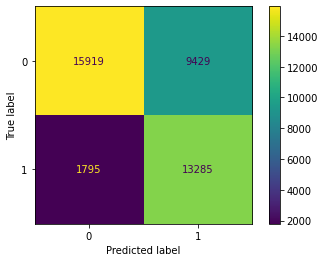

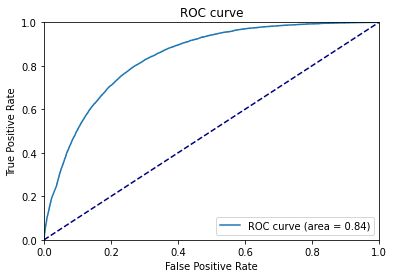

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

### Experiment 8: Bi-directional LSTM with trainable embedding + Data Augmentation

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_bi_augm_glove-100_m-len-15.h5'))

In [ ]:
for layer in model.layers:
  if layer.name == 'embedding':
    layer.trainable = True
compile_model(model, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      9668900     ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 bidirectional (Bidirectional)  (None, 20)           8880        ['embedding[0][0]',          

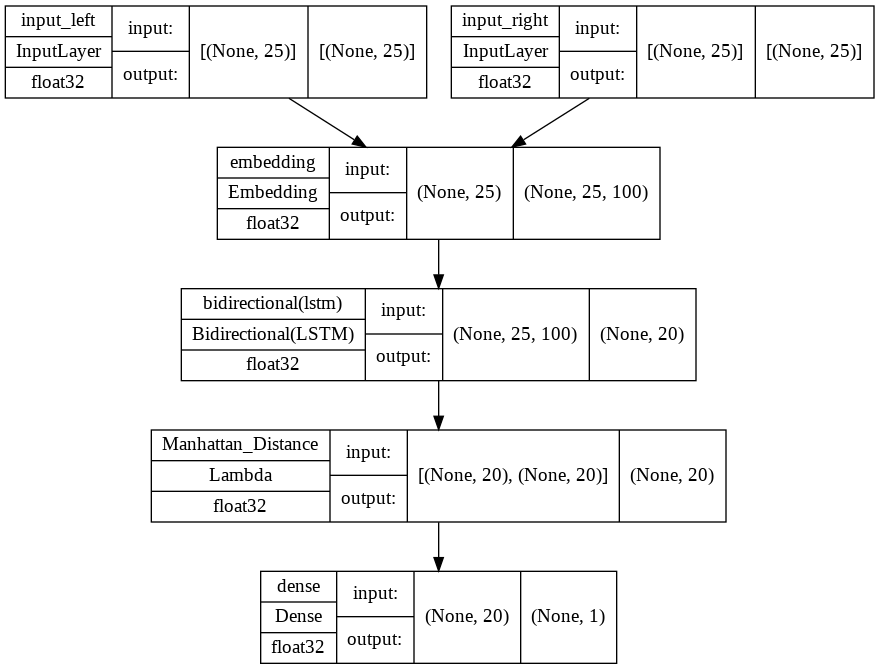

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

In [15]:
def get_samples(df, max_length):
  left = df[['tokenizer_1']]
  right = df[['tokenizer_2']]
  return sequence.pad_sequences(left.tokenizer_1, maxlen = max_length, padding='post', truncating='post'), sequence.pad_sequences(right.tokenizer_2, maxlen=max_length, padding='post', truncating='post')

In [16]:
m_len = 25

In [17]:
x_train_left, x_train_right = get_samples(augmented_train_questions, m_len)
y_train = augmented_train_questions[['is_duplicate']]

x_val_left, x_val_right = get_samples(validation_questions, m_len)
y_val = validation_questions[['is_duplicate']]

x_test_left, x_test_right = get_samples(test_questions, m_len)
y_test = test_questions[['is_duplicate']]

In [18]:
x_train_left.shape == x_train_right.shape

True

In [19]:
len(x_train_left) == len(y_train)

True

Epoch 1/20
6382/6382 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.7874
Epoch 1: val_loss improved from inf to 0.14903, saving model to /content/Models/siamese_bi_augm-finetune_glove-100_m-len-25.h5
6382/6382 [==============================] - 1393s 216ms/step - loss: 0.1474 - accuracy: 0.7874 - val_loss: 0.1490 - val_accuracy: 0.7827
Epoch 2/20
6382/6382 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.8300
Epoch 2: val_loss improved from 0.14903 to 0.14064, saving model to /content/Models/siamese_bi_augm-finetune_glove-100_m-len-25.h5
6382/6382 [==============================] - 1359s 213ms/step - loss: 0.1214 - accuracy: 0.8300 - val_loss: 0.1406 - val_accuracy: 0.7987
Epoch 3/20
6382/6382 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.8566
Epoch 3: val_loss improved from 0.14064 to 0.13994, saving model to /content/Models/siamese_bi_augm-finetune_glove-100_m-len-25.h5
6382/6382 [==============================

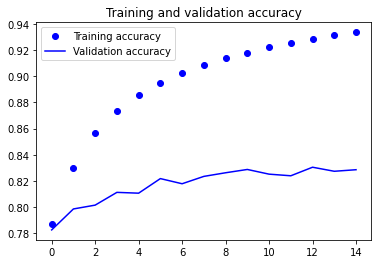

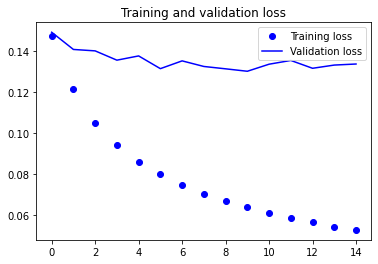

In [ ]:
run_model(model, "siamese_bi_augm-finetune_glove-100_m-len-25", [x_train_left, x_train_right], y_train, [x_val_left, x_val_right], y_val, epochs = 20)

In [ ]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_bi_augm-finetune_glove-100_m-len-25.h5'))

Classification report: 
              precision    recall  f1-score   support

           0     0.9057    0.8102    0.8553     25348
           1     0.7290    0.8583    0.7884     15080

    accuracy                         0.8281     40428
   macro avg     0.8174    0.8342    0.8218     40428
weighted avg     0.8398    0.8281    0.8303     40428



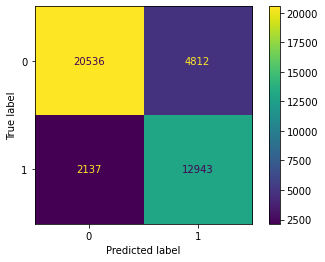

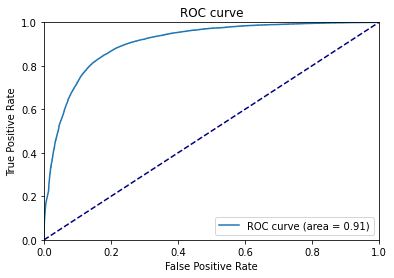

In [ ]:
evaluate_model(model, [x_test_left, x_test_right], y_test)

In [13]:
model = keras.models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'siamese_bi_augm-finetune_glove-100_m-len-25.h5'))

#### Save scores

In [20]:
test_score = model.predict([x_test_left, x_test_right])
test_score

array([[9.9985015e-01],
       [9.3571132e-01],
       [9.1084592e-05],
       ...,
       [7.4174267e-01],
       [3.9424241e-01],
       [4.0364016e-02]], dtype=float32)

In [22]:
with open('test_scores.npy', 'wb') as f:
  np.save(f, test_score)

In [24]:
!cp test_scores.npy /content/drive/MyDrive/Quora/Features/

In [21]:
val_score = model.predict([x_val_left, x_val_right])
val_score

array([[1.2166839e-04],
       [9.8037416e-01],
       [9.8969382e-01],
       ...,
       [1.5613773e-04],
       [9.8733389e-01],
       [1.2438234e-03]], dtype=float32)

In [23]:
with open('val_scores.npy', 'wb') as f:
  np.save(f, val_score)

In [25]:
!cp val_scores.npy /content/drive/MyDrive/Quora/Features/